In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Masking
from keras.callbacks import ModelCheckpoint  

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')



In [2]:
from prettytable import PrettyTable
conc = PrettyTable(["Model Name", "MSE for daily returns", "MSE for intra day returns"])

### Load raw data

In [3]:
df=pd.read_csv("train.csv")

In [4]:
df.head(5)

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [6]:
print(df.dtypes)

Id                   int64
Feature_1          float64
Feature_2          float64
Feature_3          float64
Feature_4          float64
                    ...   
Ret_180            float64
Ret_PlusOne        float64
Ret_PlusTwo        float64
Weight_Intraday    float64
Weight_Daily       float64
Length: 211, dtype: object


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 211 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Id               int64  
 1    Feature_1        float64
 2    Feature_2        float64
 3    Feature_3        float64
 4    Feature_4        float64
 5    Feature_5        float64
 6    Feature_6        float64
 7    Feature_7        int64  
 8    Feature_8        float64
 9    Feature_9        float64
 10   Feature_10       float64
 11   Feature_11       float64
 12   Feature_12       float64
 13   Feature_13       float64
 14   Feature_14       float64
 15   Feature_15       float64
 16   Feature_16       float64
 17   Feature_17       float64
 18   Feature_18       float64
 19   Feature_19       float64
 20   Feature_20       float64
 21   Feature_21       float64
 22   Feature_22       float64
 23   Feature_23       float64
 24   Feature_24       float64
 25   Feature_25       float64
 26   Ret_MinusTwo    

In [8]:
df.isnull().sum()

Id                     0
Feature_1          33313
Feature_2           9146
Feature_3           1237
Feature_4           7721
                   ...  
Ret_180                0
Ret_PlusOne            0
Ret_PlusTwo            0
Weight_Intraday        0
Weight_Daily           0
Length: 211, dtype: int64

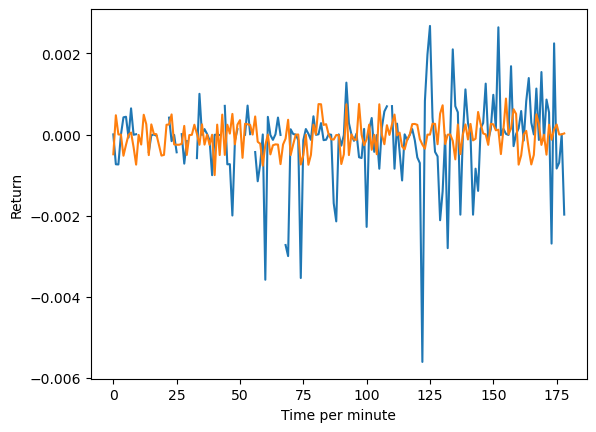

In [9]:
# sample return of starting few assets
for i in range(0,2):
    y=df.iloc[i]['Ret_2':'Ret_180']
    x=range(0,len(y))
    plt.plot(x,y)
plt.xlabel('Time per minute')
plt.ylabel('Return')
plt.show()

In [10]:
# replacing NAN values with zero
df.fillna(value=0,inplace=True)

In [11]:
#imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
#imputer = imputer.fit(df.values)
#df_ar = imputer.transform(df)


#df_ar[:5]


#df.fillna(df.mean(axis=0), inplace=True)
# we are using the above line because it retains the datatype as Dataframe and in future code 
#    it will be easy to access through column names

In [12]:
df.isnull().sum()

Id                 0
Feature_1          0
Feature_2          0
Feature_3          0
Feature_4          0
                  ..
Ret_180            0
Ret_PlusOne        0
Ret_PlusTwo        0
Weight_Intraday    0
Weight_Daily       0
Length: 211, dtype: int64

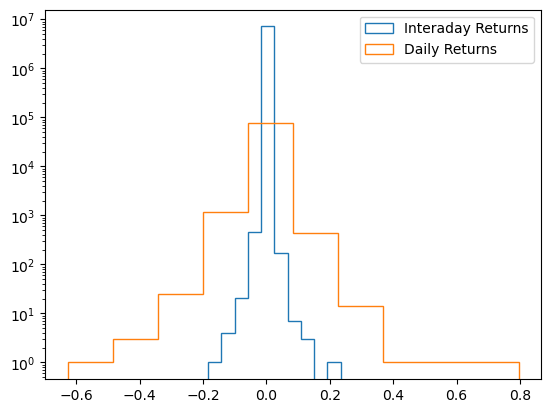

In [13]:
#let visualize the disribution of intraday and daily returns
# the data is very huge hence using log scale on y axis
plt.hist(df.loc[:,"Ret_2":"Ret_180"].values.flatten(),log=True,histtype='step',label='Interaday Returns')

plt.hist(df.loc[:,"Ret_PlusOne":"Ret_PlusTwo"].values.flatten(),log=True,histtype='step',label='Daily Returns')


plt.legend()
plt.show()

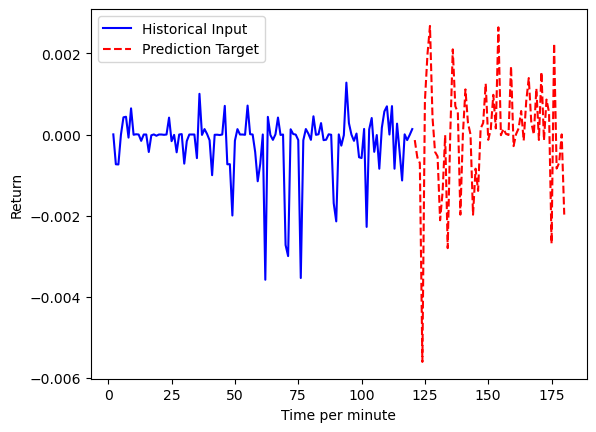

In [14]:
# Visualising target variables for a sample asset

sample_y = df.iloc[0]

sample_hist_y = sample_y['Ret_2':'Ret_120']
sample_target_y = sample_y['Ret_121':'Ret_180']

sample_hist_x = range(2,121)
sample_target_x=range(121,181)


plt.plot(sample_hist_x,sample_hist_y, 'b-', label='Historical Input')
plt.plot(sample_target_x,sample_target_y, 'r--', label='Prediction Target')

plt.xlabel("Time per minute")
plt.ylabel("Return")
plt.legend()
plt.show()

# Data Preprocessing

In [15]:
df.columns.values

array(['Id', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4',
       'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9',
       'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13',
       'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17',
       'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21',
       'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25',
       'Ret_MinusTwo', 'Ret_MinusOne', 'Ret_2', 'Ret_3', 'Ret_4', 'Ret_5',
       'Ret_6', 'Ret_7', 'Ret_8', 'Ret_9', 'Ret_10', 'Ret_11', 'Ret_12',
       'Ret_13', 'Ret_14', 'Ret_15', 'Ret_16', 'Ret_17', 'Ret_18',
       'Ret_19', 'Ret_20', 'Ret_21', 'Ret_22', 'Ret_23', 'Ret_24',
       'Ret_25', 'Ret_26', 'Ret_27', 'Ret_28', 'Ret_29', 'Ret_30',
       'Ret_31', 'Ret_32', 'Ret_33', 'Ret_34', 'Ret_35', 'Ret_36',
       'Ret_37', 'Ret_38', 'Ret_39', 'Ret_40', 'Ret_41', 'Ret_42',
       'Ret_43', 'Ret_44', 'Ret_45', 'Ret_46', 'Ret_47', 'Ret_48',
       'Ret_49', 'Ret_50', 'Ret_51', 'Ret_52', 'Ret_53', 'Ret

In [16]:
n_features = 25                          # number of feature total 25
n_return_inputs = 119+2                  # Ret_2 to ret_120 + Ret_MinusTwo, Ret_MinusOne
n_return_intraday_output = 60            # Ret_121 to Ret_180
n_return_daily_output = 2                # Ret_PlusOne , Ret_PlusTwo


X=df.loc[:,'Feature_1':'Ret_120']        # Features as well as input returns 
y=df.loc[:,'Ret_121':'Weight_Daily']     # output return and weights , weights will be seperated while using train_test_split


X_train_raw, X_test_raw , y_train_raw , y_test_raw = train_test_split(X,y,test_size=0.20, random_state=42)

In [17]:
def preprocess_data(x_raw,y_raw):
    # transform input into 3d matrix: samples x timesteps x features
    features = x_raw.loc[:, 'Feature_1':'Feature_25'].values[:,None,:]
    
    returns_intraday = x_raw.loc[:,'Ret_2':'Ret_120'].values[:,:,None]
    features_repeated = np.repeat(features,returns_intraday.shape[1],axis=1) # for each sample duplicate the features for each timestep
    X_intraday = np.dstack((features_repeated, returns_intraday))
    
    returns_daily = x_raw.loc[:,'Ret_MinusTwo':'Ret_MinusOne'].values[:,:,None]
    features_repeated = np.repeat(features,returns_daily.shape[1],axis=1) # for each sample duplicate the features for each timestep
    X_daily = np.dstack((features_repeated, returns_daily))
    
    
    X_combined = x_raw.loc[:,'Ret_MinusTwo':'Ret_120'].values[:,:,None]
    features_repeated=np.repeat(features,X_combined.shape[1],axis=1)
    X_combined = np.dstack((features_repeated,X_combined))
    
    
    # targets should consist of returns only
    y_intraday = y_raw.loc[:,'Ret_121':'Ret_180']
    y_daily = y_raw.loc[:,'Ret_PlusOne':'Ret_PlusTwo']
    y_combined = y_raw.loc[:,'Ret_121':'Ret_PlusTwo']
    
    
    weights_intraday= y_raw.loc[:,'Weight_Intraday']
    weights_daily= y_raw.loc[:,'Weight_Daily']
    
    return X_intraday, X_daily, y_intraday, y_daily, X_combined, y_combined, \
           weights_intraday, weights_daily


### Steps:- 
1.It extracts and reshapes the features and intraday returns data into a 3D matrix, where the dimensions are samples x timesteps x features.

2.It does the same for the features and daily returns data.

3.It combines the features with returns data to create a combined 3D matrix for both intraday and daily predictions.

4.It separates the targets into intraday and daily returns.

5.It separates the weights for intraday and daily predictions.

### Description

In the line features_repeated = np.repeat(features, returns_intraday.shape[1], axis=1), the None is used to add a new axis to the features matrix. It's equivalent to using np.newaxis. This is done to ensure proper alignment and broadcasting when repeating the matrix.

Here's a breakdown:

features is a 3D matrix with dimensions (samples x timesteps x features).
returns_intraday.shape[1] gives the number of timesteps in the intraday returns matrix.
The None or np.newaxis is used to add a new axis along which the repetition will occur. In this case, it's added along the second axis (axis=1), which represents the timesteps.

So, features[:, None, :] creates a 3D matrix with dimensions (samples x 1 x features), effectively adding a new axis between the existing axes. This ensures that when you repeat this matrix along the second axis, each feature will be repeated for each timestep.

The resulting X_daily matrix will have dimensions (samples x timesteps x features + 1), where the last dimension corresponds to the combined information of repeated features and daily returns.

This portion of the code is preparing the target variables (y_intraday, y_daily, y_combined) and weight variables (weights_intraday, weights_daily) for the machine learning task.

This portion of the code is preparing the target variables (y_intraday, y_daily, y_combined) and weight variables (weights_intraday, weights_daily) for the machine learning task.

### Return Processed Data:

The function then returns all these processed variables (X_intraday, X_daily, y_intraday, y_daily, X_combined, y_combined, weights_intraday, weights_daily). These variables are now ready to be used as input for training machine learning models, where X_intraday and X_daily are the input features, y_intraday and y_daily are the target returns, and weights_intraday and weights_daily are the associated weights.
''

In [18]:
X_train_intraday, X_train_daily, y_train_intraday, y_train_daily, \
X_train_combined, y_train_combined, \
weights_train_intraday, weights_train_daily = preprocess_data(X_train_raw, y_train_raw)

X_test_intraday, X_test_daily, y_test_intraday, y_test_daily, \
X_test_combined, y_test_combined, \
weights_test_intraday, weights_test_daily = preprocess_data(X_test_raw, y_test_raw)

# Training the model
### NOTE:
Regression models can be effective for tasks where the relationship between features and targets is relatively straightforward and doesn't involve complex temporal dependencies.This problem involves capturing patterns and relationships that depend on the sequence and timing of events hence using LSTM model for this project

## LSTM Model with masking layer

In [19]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='relu',
                     dropout=.4, loss='mae', loss_weights=None, sample_weight_mode=None, optimizer='adam'):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))

    model.add(Dropout(dropout))
    model.add(Dense(units=2 * neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, loss_weights=loss_weights, sample_weight_mode=sample_weight_mode, optimizer=optimizer)
    print(model.summary())
    return model

### Model for daily returns


In [143]:
# Initial testing/tuning only, slow and poor convergence!
'''
lstm_neurons = 20
epochs = 3
batch_size = 100
loss = 'mae'
dropout = 0.40
optimizer = 'adam'
activ_func = 'linear'

checkpointer_tuning = ModelCheckpoint(filepath='saved_models/best_weights_daily_tuning.hdf5', 
                               verbose=1, save_best_only=True)
model_tuning = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_tuning = model_tuning.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                            #sample_weight=weights_train_daily
                          epochs=epochs, callbacks=[checkpointer_tuning])
'''

"\nlstm_neurons = 20\nepochs = 3\nbatch_size = 100\nloss = 'mae'\ndropout = 0.40\noptimizer = 'adam'\nactiv_func = 'linear'\n\ncheckpointer_tuning = ModelCheckpoint(filepath='saved_models/best_weights_daily_tuning.hdf5', \n                               verbose=1, save_best_only=True)\nmodel_tuning = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, \n                               activ_func=activ_func, optimizer=optimizer,\n                               dropout=dropout)\nhistory_tuning = model_tuning.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, \n                           verbose=1, shuffle=True,\n                            #sample_weight=weights_train_daily\n                          epochs=epochs, callbacks=[checkpointer_tuning])\n"

In [144]:
''''
lstm_neurons = 100
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_daily = ModelCheckpoint(filepath='saved_models/best_weights_daily.hdf5', 
                               verbose=1, save_best_only=True)
model_daily = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_daily = model_daily.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                            #sample_weight=weights_train_daily, causes loss function to be nan
                          epochs=epochs, callbacks=[checkpointer_daily])
'''                

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_5 (Masking)         (None, 2, 26)             0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               50800     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 200)               20200     
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 402       
                                                                 
 activation_5 (Activation)   (None, 2)                

In [145]:
m1=mean_absolute_error(y_test_daily,y_pred_daily)    

In [63]:
'''
# lstm masking layer with replacing nan with mean
lstm_neurons = 100
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_daily = ModelCheckpoint(filepath='saved_models/best_weights_daily.hdf5', 
                               verbose=1, save_best_only=True)
model_daily = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_daily = model_daily.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                            #sample_weight=weights_train_daily, causes loss function to be nan
                          epochs=epochs, callbacks=[checkpointer_daily])
'''

Epoch 1/3
47/48 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 1: val_loss improved from inf to 0.01537, saving model to saved_models\best_weights_daily.hdf5
48/48 [==============================] - 13s 98ms/step - loss: 0.0248 - val_loss: 0.0154
Epoch 2/3
47/48 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 2: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 33ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 3/3
46/48 [===========================>..] - ETA: 0s - loss: 0.0155
Epoch 3: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 33ms/step - loss: 0.0155 - val_loss: 0.0154


### Model for intraday returns

In [146]:

lstm_neurons = 250
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_intraday = ModelCheckpoint(filepath='saved_models/best_weights_intraday.hdf5', 
                               verbose=1, save_best_only=True)
model_intraday = build_lstm_model(X_train_intraday, y_train_intraday.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_intraday = model_intraday.fit(X_train_intraday, y_train_intraday, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                            #sample_weight=y_train_weights_daily,
                          epochs=epochs, callbacks=[checkpointer_intraday])



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_6 (Masking)         (None, 119, 26)           0         
                                                                 
 lstm_6 (LSTM)               (None, 250)               277000    
                                                                 
 dropout_12 (Dropout)        (None, 250)               0         
                                                                 
 dense_18 (Dense)            (None, 500)               125500    
                                                                 
 dropout_13 (Dropout)        (None, 500)               0         
                                                                 
 dense_19 (Dense)            (None, 60)                30060     
                                                                 
 activation_6 (Activation)   (None, 60)               

In [150]:
m2= mean_absolute_error(y_test_intraday, y_pred)
conc.add_row(["LSTM Model With masking layer", m1, m2])
print(conc)

+-------------------------------+-----------------------+---------------------------+
|           Model Name          | MSE for daily returns | MSE for intra day returns |
+-------------------------------+-----------------------+---------------------------+
| LSTM Model With masking layer |  0.01572343120030032  |   0.0006309781884666323   |
+-------------------------------+-----------------------+---------------------------+


In [64]:
''''
# lstm masking layer with replacing nan with mean
lstm_neurons = 250
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_intraday = ModelCheckpoint(filepath='saved_models/best_weights_intraday.hdf5', 
                               verbose=1, save_best_only=True)
model_intraday = build_lstm_model(X_train_intraday, y_train_intraday.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_intraday = model_intraday.fit(X_train_intraday, y_train_intraday, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                            #sample_weight=y_train_weights_daily,
                          epochs=epochs, callbacks=[checkpointer_intraday])
'''

Epoch 1/3
48/48 [==============================] - ETA: 0s - loss: 0.0074
Epoch 1: val_loss improved from inf to 0.00063, saving model to saved_models\best_weights_intraday.hdf5
48/48 [==============================] - 447s 9s/step - loss: 0.0074 - val_loss: 6.3264e-04
Epoch 2/3
48/48 [==============================] - ETA: 0s - loss: 6.3430e-04
Epoch 2: val_loss did not improve from 0.00063
48/48 [==============================] - 348s 7s/step - loss: 6.3430e-04 - val_loss: 6.3264e-04
Epoch 3/3
48/48 [==============================] - ETA: 0s - loss: 6.3417e-04
Epoch 3: val_loss did not improve from 0.00063
48/48 [==============================] - 298s 6s/step - loss: 6.3417e-04 - val_loss: 6.3264e-04


# Results

In [66]:
def plot_sample_predictions(predictions, actual, samples=6):
    cols = min(samples, 3) # at most 3 columns
    rows = int(np.ceil(samples/3))  # i.e 3 graphs per row
    plt.figure(figsize=(5 * cols, 3 * rows))
     
    for i in range(1, samples + 1):
        plt.subplot(rows, cols, i)
        plt.plot(range(0, len(y_pred[i])), predictions[i], 'b-', label='predicted')
        plt.plot(range(0, len(y_pred[i])), actual[i], 'r--', label='actual') 
    plt.show()

### Daily Returns:

250/250 [==============================] - 1s 4ms/step
Weighted Mean Abosolute Error on testing set:
Model:  0.01572343120030032
Zero benchmark:  0.01572343120030032


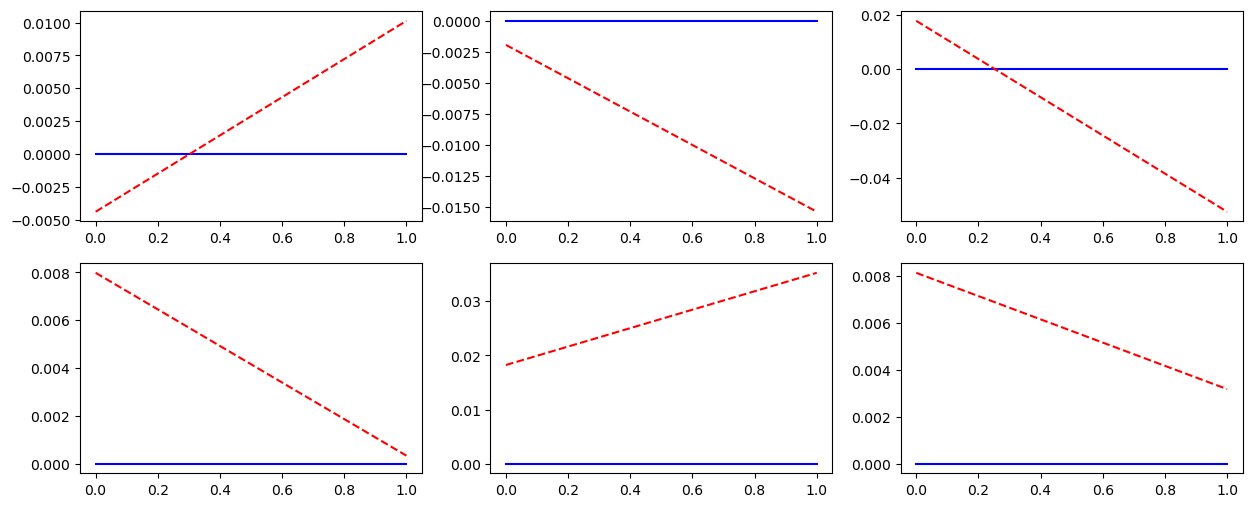

In [85]:
y_pred_daily = model_daily.predict(X_test_daily)
zero_prediction = np.zeros(y_pred_daily.shape)

print('Weighted Mean Abosolute Error on testing set:')
print('Model: ', mean_absolute_error(y_test_daily, y_pred_daily))
print('Zero benchmark: ', mean_absolute_error(y_test_daily, zero_prediction))
plot_sample_predictions(predictions=y_pred_daily, actual=y_test_daily.values)

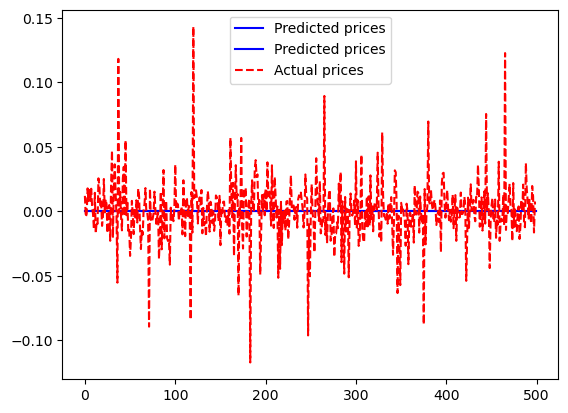

In [87]:
plt.plot(range(0, len(y_test_daily[:500])), y_pred_daily[:500], 'b-', label='Predicted prices')
plt.plot(range(0, len(y_test_daily[:500])),y_test_daily['Ret_PlusOne'][:500], 'r--', label='Actual prices')
plt.legend()
plt.show()

250/250 [==============================] - 34s 135ms/step
Weighted Mean Abosolute Error on testing set:
Model:  0.0006309781884666323
Zero benchmark:  0.0006309781884666323


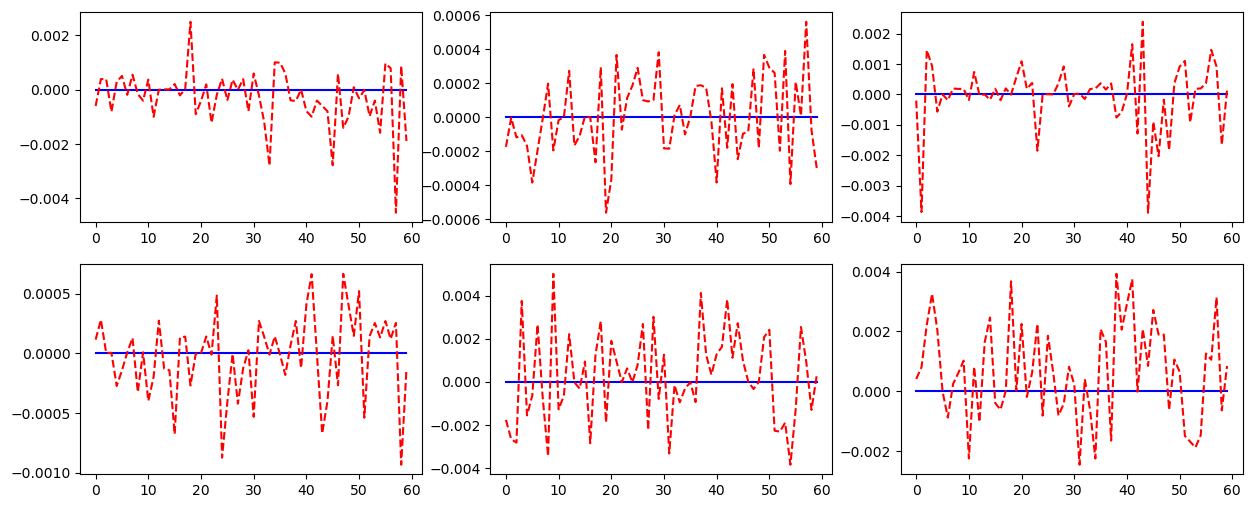

In [89]:
y_pred = model_intraday.predict(X_test_intraday)
zero_prediction = np.zeros(y_pred.shape)

print('Weighted Mean Abosolute Error on testing set:')
print('Model: ', mean_absolute_error(y_test_intraday, y_pred))
print('Zero benchmark: ', mean_absolute_error(y_test_intraday, zero_prediction))
plot_sample_predictions(predictions=y_pred, actual=y_test_intraday.values)


In [152]:
m1= mean_absolute_error(y_test_intraday, y_pred)
m2=mean_absolute_error(y_test_daily,y_pred_daily)

In [153]:
conc.add_row(["LSTM Model With masking layer replacing NAN with mean", m1, m2])
print(conc)

+-------------------------------------------------------+-----------------------+---------------------------+
|                       Model Name                      | MSE for daily returns | MSE for intra day returns |
+-------------------------------------------------------+-----------------------+---------------------------+
|             LSTM Model With masking layer             |  0.01572343120030032  |   0.0006309781884666323   |
| LSTM Model With masking layer replacing NAN with mean | 0.0006309781884666323 |    0.01572343120030032    |
+-------------------------------------------------------+-----------------------+---------------------------+


In [159]:
def plot_stock_price(actual_returns, base_price=100, samples=6):
    returns_list = actual_returns[:samples].copy()
    cols = min(samples, 3)  # at most 3 columns
    rows = int(np.ceil(samples/3))  # 3 graphs per row
    plt.figure(figsize=(5 * cols, 3 * rows))
    
    for i in range(0, samples):
        plt.subplot(rows, cols, i+1)
    
        # assuming the data provided are returns over minute intervals
        returns_list[i] += 1  
        returns_list[i] = np.cumprod(returns_list[i])
        actual_prices = returns_list[i] * base_price

        plt.plot(range(0, len(actual_prices)), actual_prices, 'b-', label='Actual prices')
        # zero return, shifted by 1 step in the x-axis
        plt.plot(range(1, len(actual_prices)), actual_prices[:-1], 'r--', label='Predicted prices')
        plt.legend()
    plt.show()

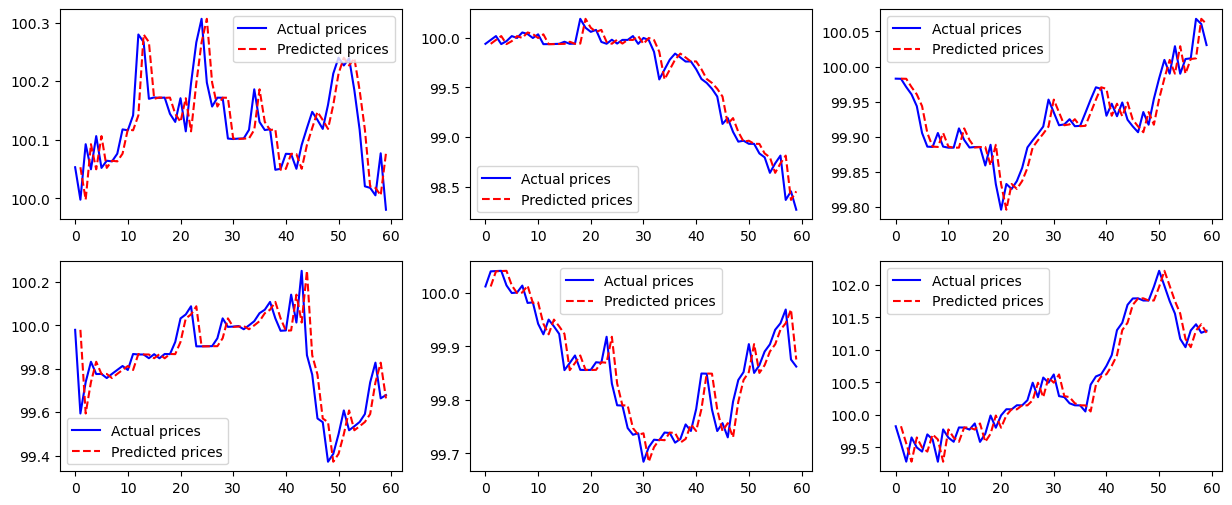

In [160]:
plot_stock_price(y_test_intraday.values)

In [20]:
'''
# lstm masking layer with replacing nan with mean
lstm_neurons = 100
epochs = 100
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_daily = ModelCheckpoint(filepath='saved_models/best_weights_daily.hdf5', 
                               verbose=1, save_best_only=True)
model_daily = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_daily = model_daily.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                            #sample_weight=weights_train_daily, causes loss function to be nan
                          epochs=epochs, callbacks=[checkpointer_daily])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 2, 26)             0         
                                                                 
 lstm (LSTM)                 (None, 100)               50800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 200)               20200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
 activation (Activation)     (None, 2)                 0

Epoch 33/100
47/48 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 33: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 32ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 34/100
48/48 [==============================] - ETA: 0s - loss: 0.0155
Epoch 34: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 34ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 35/100
46/48 [===========================>..] - ETA: 0s - loss: 0.0155
Epoch 35: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 32ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 36/100
47/48 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 36: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 34ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 37/100
48/48 [==============================] - ETA: 0s - loss: 0.0155
Epoch 37: val_loss did not improve from 0.01537
48/48 [================

48/48 [==============================] - 2s 34ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 72/100
47/48 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 72: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 34ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 73/100
48/48 [==============================] - ETA: 0s - loss: 0.0155
Epoch 73: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 33ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 74/100
47/48 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 74: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 33ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 75/100
47/48 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 75: val_loss did not improve from 0.01537
48/48 [==============================] - 2s 34ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 76/100
47/48 [============================>.] - ETA: 0